# TP3 Visión por Computadora 1 CEIA FIUBA

Profesor: Ing. Maxim Dorogov
Autores:
        Alvarez, Jorge Adrián
        Peñaranda Peralta, Daniel Eduardo

**Objetivo:**
Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en */images* a partir del ***template*** */template*.

1. Obtener una detección del logo en cada imagen sin falsos positivos
2. Plantear y validar un algoritmo para múltiples detecciones en la imagen *coca_multi.png* con el mismo *template* del ítem1
3. Generalizar el algoritmo del item2 para todas las imágenes.
Visualizar los resultados con *bounding boxes* en cada imagen mostrando el nivel de confianza de la detección.

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

A continuación se definen un grupo de funciones que serán usadas recurrentemente en el desarrollo del trabajo.

In [ ]:

def denoise(img, k=3):
   return cv.GaussianBlur(img, (k, k), 0)

def obtener_bordes(img, low=100, high=200):
    bordes = cv.Canny(img, low, high)
    return bordes

def dibujar_homografia(template, scene, H, inliers_count, total_matches, color='green'):
    h, w = template.shape[:2]

    # Esquinas del template
    corners = np.float32([[0,0], [w,0], [w,h], [0,h]]).reshape(-1,1,2)

    proj = cv.perspectiveTransform(corners, H).reshape(-1,2)

    # Calcular confianza
    confidence = inliers_count / total_matches if total_matches > 0 else 0.0

    # Mostrar escena
    plt.figure(figsize=(10,6))
    plt.imshow(scene, cmap='gray' if scene.ndim == 2 else None)

    # Dibujar polígono del template proyectado
    xs, ys = proj[:,0], proj[:,1]
    plt.plot(
        np.r_[xs, xs[0]],
        np.r_[ys, ys[0]],
        linewidth=3,
        color=color
    )

    # Posición del texto = primera esquina proyectada
    x_text, y_text = proj[0]

    # Dibujar confianza encima del polígono (mismo color)
    plt.text(
        x_text,
        y_text - 10,   # un poco arriba del vértice
        f'{confidence:.2f}',
        fontsize=14,
        color=color,
        bbox=dict(facecolor='black', alpha=0.5, edgecolor='none')
    )

    plt.axis('off')
    plt.show()

    return None

def mostrar_matches(img_template, kp1, img_scene, kp2, matches):
    '''
    Dibuja los matches entre template y escena usando matplotlib.
    '''
    # Dibujar matches con OpenCV
    img_matches = cv.drawMatches(
        img_template, kp1,
        img_scene, kp2,
        matches,
        None,
        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    if img_matches is None:
        raise ValueError('img_matches es None')

    # Convertir de BGR a RGB para matplotlib
    img_matches_rgb = cv.cvtColor(img_matches, cv.COLOR_BGR2RGB)

    # Mostrar
    plt.figure(figsize=(18, 8))
    plt.imshow(img_matches_rgb)
    plt.axis('off')
    plt.show()

    return None

def suprimir_no_maximos(boxes, overlapThresh=0.3):
    
    """
    Usa supresión no-máximo: ordena las cajas
    por score y conserva las de mayor confianza
    eliminando las que se solapan por encima de overlapThresh.
    
    """
    
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    scores = boxes[:,4]

    idxs = np.argsort(scores)[::-1]

    picked = []

    while len(idxs) > 0:
        i = idxs[0]
        picked.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])

        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        overlap = (w * h) / ((x2[idxs[1:]] - x1[idxs[1:]]) * (y2[idxs[1:]] - y1[idxs[1:]]))

        idxs = idxs[np.where(overlap < overlapThresh)[0] + 1]

    return boxes[picked].astype(int)


## 1. Obtener una detección del logo en cada imagen sin falsos positivos

Se realizó una exploración rápida y se observó, inicialmente, que hacer el match usando la imagen directamente no daba buenos resultados *out of the box*.

Como se buscaba un logo con lineas tan particulares se decidió usar canny para extraer los bordes y usarlos para un match por descriptores.

Los descriptores hallados, luego se pasaron por un filtro de `RANSAC` para dejar solo los geométricamente consistentes.

La métrica de confianza se expresó en proporción de descriptores consistentes sobre descriptores totales.

Los parámetros más determinantes para lograr una detección correcta fueron el umbral utilizado para descartar coincidencias ambiguas y la escala aplicada al *template*; el ajuste adecuado de ambos resultó esencial para obtener resultados fiables.

En los casos en que se utilizó **detección por descriptores**, **no** se fue necesario **redimensionar** el *template*, debido a que esta metodología es indiferente a la escala.

En ninguno de los casos se consideró rotación.

In [3]:
# Cargar template
img_template_original = cv.imread(r'template\pattern.png', cv.IMREAD_GRAYSCALE)

Matches buenos: 15
Inliers: 13


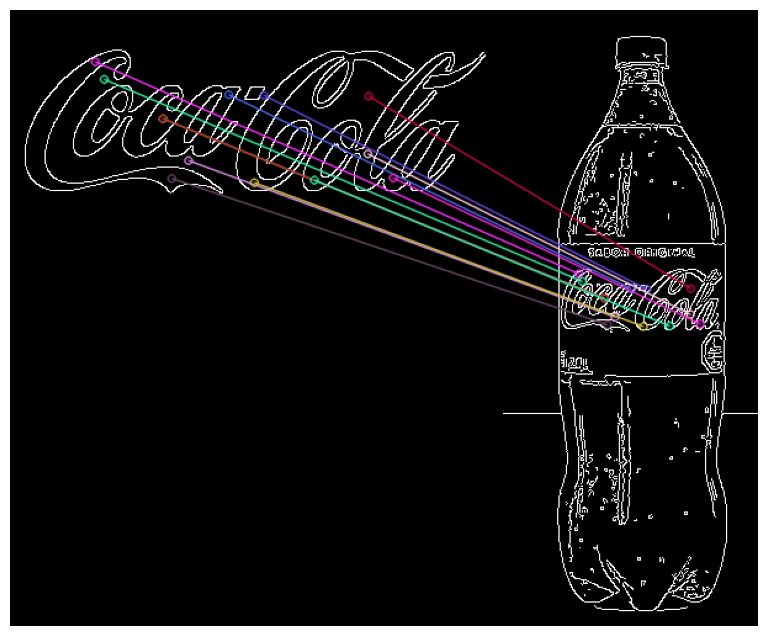

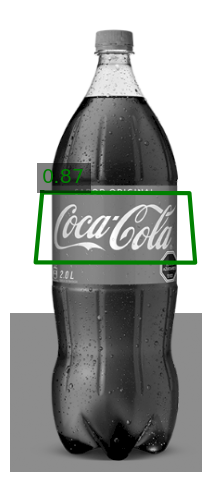

In [ ]:
# Imagen 1
img_scene_original = cv.imread(r'images\coca_logo_1.png', cv.IMREAD_GRAYSCALE)

img_scene = obtener_bordes(img_scene_original)
img_template = obtener_bordes(img_template_original)

# Inicializar SIFT
sift = cv.SIFT_create()

# Detectar keypoints y descriptores
kp1, des1 = sift.detectAndCompute(img_template, None)
kp2, des2 = sift.detectAndCompute(img_scene, None)

# FLANN matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=10)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)

# Matching
matches = flann.knnMatch(des1, des2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance: #descartamos matches ambiguos, nos quedamos con los match que son mejores que el comparado
        good.append(m)

print('Matches buenos:', len(good))

src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

# --- RANSAC ---
H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 10.0)

if H is not None:

    # Filtrar solo inliers (coherentes geométricamente)
    mask = mask.ravel()
    inliers = [g for g, m in zip(good, mask) if m == 1]
    print("Inliers:", len(inliers))

    # Obtener bounding box del template
    h, w = img_template.shape
    corners = np.float32([[0,0], [w,0]])


mostrar_matches(img_template, kp1, img_scene, kp2, inliers)
dibujar_homografia(img_template, img_scene_original, H, len(inliers), len(good))

Matches buenos: 14
Inliers: 12


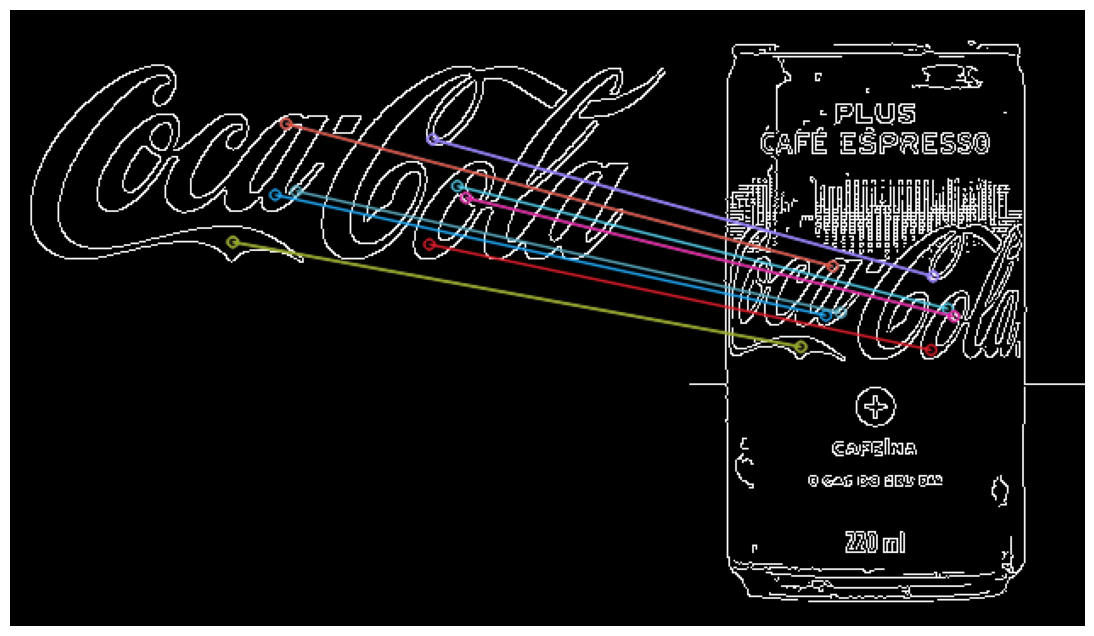

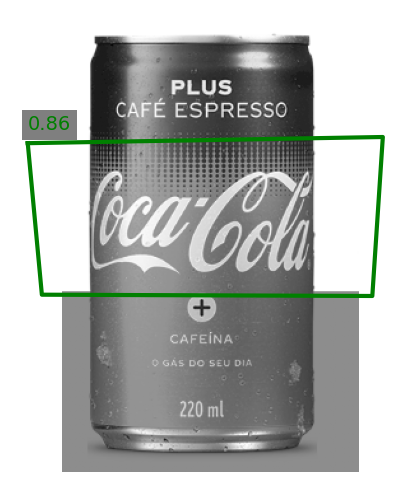

In [5]:
# Imagen 2
img_scene_original = cv.imread(r'images\coca_logo_2.png', cv.IMREAD_GRAYSCALE)

img_scene = obtener_bordes(img_scene_original)
img_template = obtener_bordes(img_template_original)

# Inicializar SIFT
sift = cv.SIFT_create()

# Detectar keypoints y descriptores
kp1, des1 = sift.detectAndCompute(img_template, None)
kp2, des2 = sift.detectAndCompute(img_scene, None)

# FLANN matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=10)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)

# Matching
matches = flann.knnMatch(des1, des2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.5 * n.distance:
        good.append(m)

print('Matches buenos:', len(good))

src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

# --- RANSAC ---
H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 10.0)

if H is not None:

    # Filtrar solo inliers (coherentes geométricamente)
    mask = mask.ravel()
    inliers = [g for g, m in zip(good, mask) if m == 1]
    print('Inliers:', len(inliers))

    # Obtener bounding box del template
    h, w = img_template.shape
    corners = np.float32([[0,0], [w,0]])


mostrar_matches(img_template, kp1, img_scene, kp2, inliers)
dibujar_homografia(img_template, img_scene_original, H, len(inliers), len(good))

Matches buenos: 50
Inliers: 14


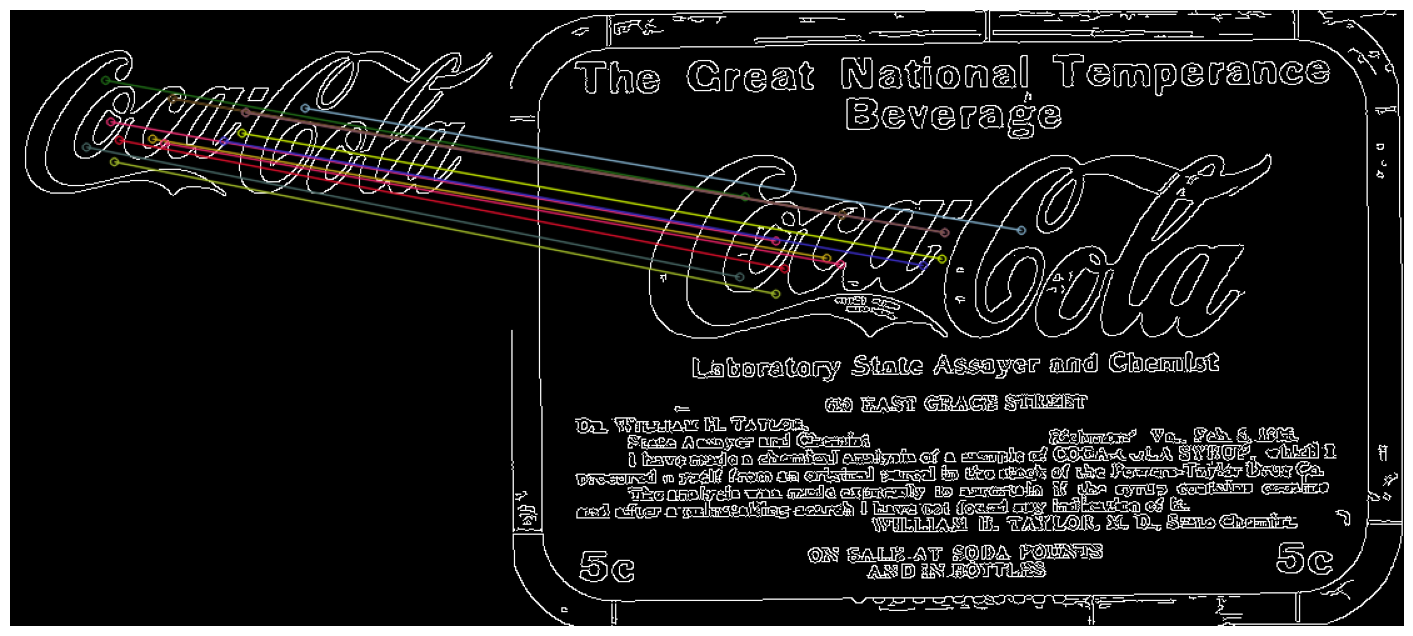

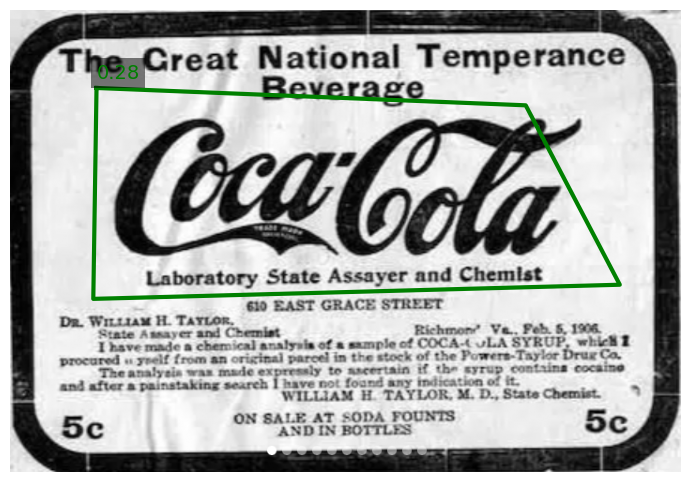

In [6]:
# Imagen 3
img_scene_original = cv.imread(r'images\coca_retro_1.png', cv.IMREAD_GRAYSCALE)

img_scene = obtener_bordes(img_scene_original)
img_template = obtener_bordes(img_template_original)

# Inicializar SIFT
sift = cv.SIFT_create()

# Detectar keypoints y descriptores
kp1, des1 = sift.detectAndCompute(img_template, None)
kp2, des2 = sift.detectAndCompute(img_scene, None)

# FLANN matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=10)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)

# Matching
matches = flann.knnMatch(des1, des2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.92 * n.distance:
        good.append(m)

print('Matches buenos:', len(good))

src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

# --- RANSAC ---
H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 10.0)

if H is not None:

    # Filtrar solo inliers (coherentes geométricamente)
    mask = mask.ravel()
    inliers = [g for g, m in zip(good, mask) if m == 1]
    print('Inliers:', len(inliers))

    # Obtener bounding box del template
    h, w = img_template.shape
    corners = np.float32([[0,0], [w,0]])


mostrar_matches(img_template, kp1, img_scene, kp2, inliers)
dibujar_homografia(img_template, img_scene_original, H, len(inliers), len(good))

Matches buenos: 68
Inliers: 28


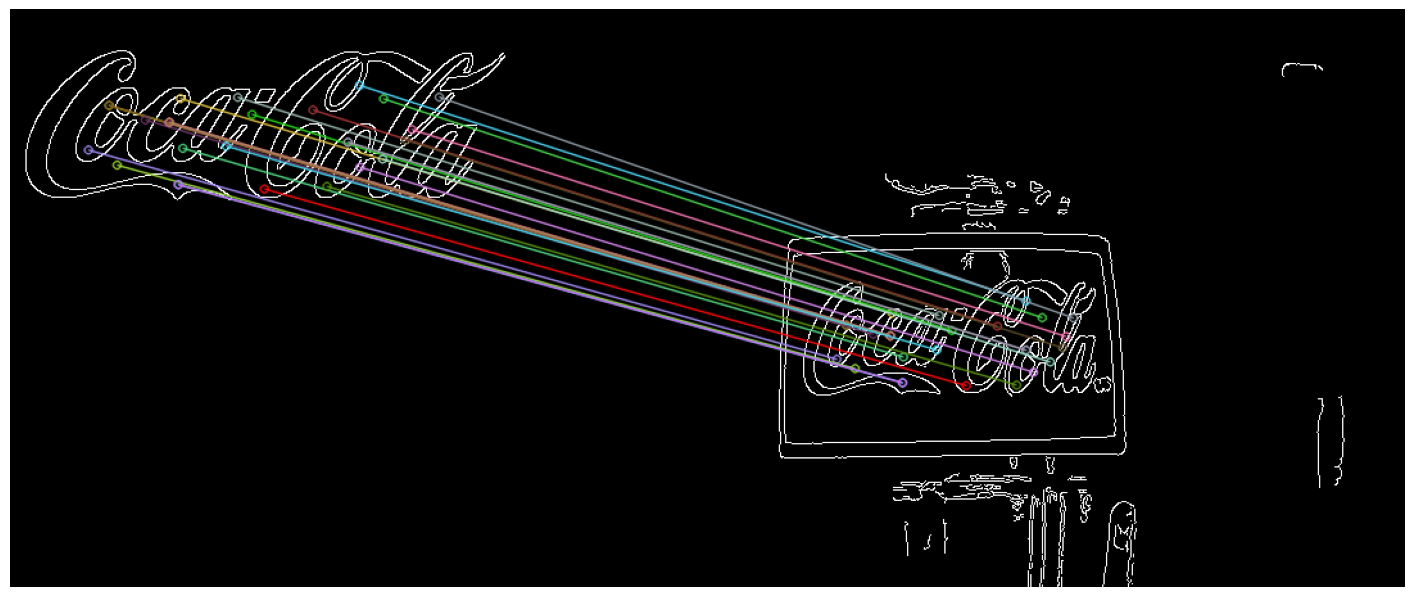

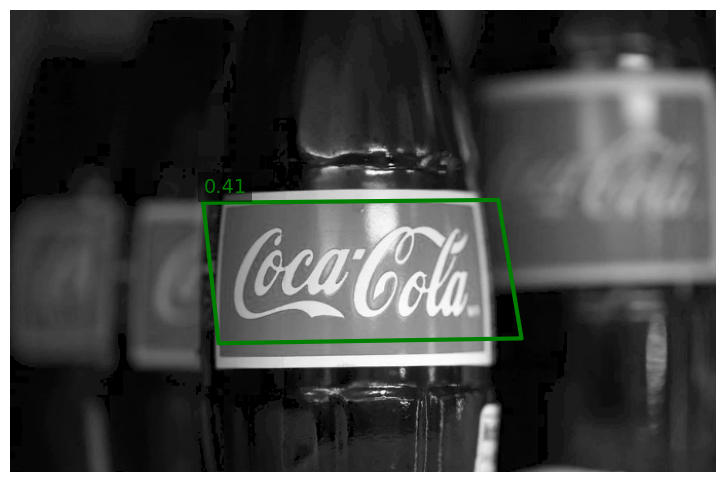

In [7]:
# Imagen 4
img_scene_original = cv.imread(r'images\logo_1.png', cv.IMREAD_GRAYSCALE)

img_scene = obtener_bordes(img_scene_original)
img_template = obtener_bordes(img_template_original)

# Inicializar SIFT
sift = cv.SIFT_create()

# Detectar keypoints y descriptores
kp1, des1 = sift.detectAndCompute(img_template, None)
kp2, des2 = sift.detectAndCompute(img_scene, None)

# FLANN matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=10)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)

# Matching
matches = flann.knnMatch(des1, des2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.92 * n.distance:
        good.append(m)

print('Matches buenos:', len(good))

src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

# --- RANSAC ---
H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 10.0)

if H is not None:

    # Filtrar solo inliers (coherentes geométricamente)
    mask = mask.ravel()
    inliers = [g for g, m in zip(good, mask) if m == 1]
    print('Inliers:', len(inliers))

    # Obtener bounding box del template
    h, w = img_template.shape
    corners = np.float32([[0,0], [w,0]])


mostrar_matches(img_template, kp1, img_scene, kp2, inliers)
dibujar_homografia(img_template, img_scene_original, H, len(inliers), len(good))


La descripción del método que se emplea a continuación, se encuentran en la función generalizada (sección 3 del trabajo)

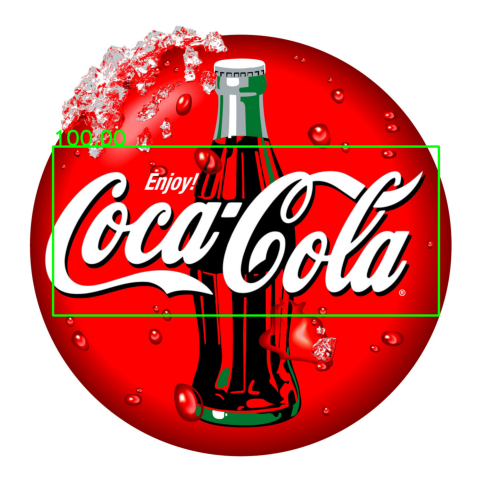

In [ ]:
#Imagen 6

img_rgb = cv.imread('images\COCA-COLA-LOGO.jpg')

img_template = img_template_original.copy()
scale = 2.9
img_template = cv.resize(img_template, None, fx=scale, fy=scale, interpolation=cv.INTER_AREA)
img_template = cv.bitwise_not(img_template)

# --- Edges / Gradientes ---
# Convertir a gris
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

# Gradiente magnitud en la imagen
sobelx = cv.Sobel(img_gray, cv.CV_32F, 1, 0)
sobely = cv.Sobel(img_gray, cv.CV_32F, 0, 1)
gx = cv.magnitude(sobelx, sobely)

# Gradiente magnitud en el template
tsobelx = cv.Sobel(img_template, cv.CV_32F, 1, 0)
tsobely = cv.Sobel(img_template, cv.CV_32F, 0, 1)
template_gx = cv.magnitude(tsobelx, tsobely)

# Template matching
w, h = img_template.shape[::-1]
res = cv.matchTemplate(gx, template_gx, cv.TM_CCOEFF_NORMED)
res_norm = cv.normalize(res, None, 0, 1, cv.NORM_MINMAX) * 100

threshold = 0.07
loc = np.where(res >= threshold)

detections = []

for pt in zip(*loc[::-1]):
    x, y = pt
    score = res_norm[y, x]
    detections.append([x, y, x+w, y+h, score])

filtered = suprimir_no_maximos(detections, overlapThresh=0.4)

for (x1, y1, x2, y2, score) in filtered:
    cv.rectangle(img_rgb, (x1, y1), (x2, y2), (0,255,0), 5)
    cv.putText(img_rgb, f"{score:.2f}", (x1, y1 - 5),
               cv.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 5)

# Mostrar resultado
img_rgb_display = cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB)



plt.figure(figsize=(8,6))
plt.imshow(img_rgb_display)
plt.axis("off")
plt.show()

## 2. Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo template del ítem anterior.

La descripción del método se encuentran en la función generalizada (sección 3 del trabajo).

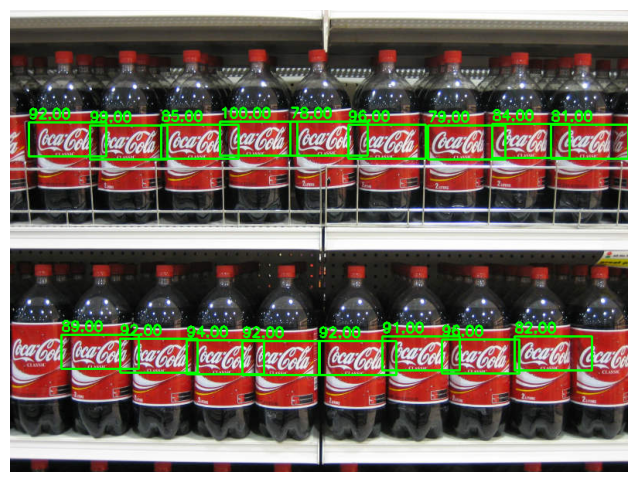

In [ ]:
# Imagen 7
# Cargar imagen y template

img_rgb = cv.imread('images/coca_multi.png')

img_template = img_template_original.copy()
scale = 0.25
img_template = cv.resize(img_template, None, fx=scale, fy=scale, interpolation=cv.INTER_AREA)
img_template = cv.bitwise_not(img_template)

# --- Edges / Gradientes ---
# Convertir a gris
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

# Gradiente magnitud en la imagen
sobelx = cv.Sobel(img_gray, cv.CV_32F, 1, 0)
sobely = cv.Sobel(img_gray, cv.CV_32F, 0, 1)
gx = cv.magnitude(sobelx, sobely)

# Gradiente magnitud en el template
tsobelx = cv.Sobel(img_template, cv.CV_32F, 1, 0)
tsobely = cv.Sobel(img_template, cv.CV_32F, 0, 1)
template_gx = cv.magnitude(tsobelx, tsobely)

# Template matching
w, h = img_template.shape[::-1]
res = cv.matchTemplate(gx, template_gx, cv.TM_CCOEFF_NORMED)
res_norm = cv.normalize(res, None, 0, 1, cv.NORM_MINMAX) * 100

threshold = 0.3
loc = np.where(res >= threshold)

detections = []

for pt in zip(*loc[::-1]):
    x, y = pt
    score = res_norm[y, x]
    detections.append([x, y, x+w, y+h, score])

filtered = suprimir_no_maximos(detections, overlapThresh=0.4)

for (x1, y1, x2, y2, score) in filtered:
    cv.rectangle(img_rgb, (x1, y1), (x2, y2), (0,255,0), 2)
    cv.putText(img_rgb, f"{score:.2f}", (x1, y1 - 5),
               cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Mostrar resultado
img_rgb_display = cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB)



plt.figure(figsize=(8,6))
plt.imshow(img_rgb_display)
plt.axis("off")
plt.show()


### 3. Generalizar el algoritmo del ítem 2 para todas las imágenes.

El enfoque basado en descriptores presentó dificultades significativas, principalmente debido a la aparición de numerosos falsos positivos. La aplicación de filtrado de bordes, `suavizado gaussiano` para reducir ruido, `binarización` y `máscaras` para excluir el color de fondo del *template* aportó mejoras parciales, pero no permitió resolver completamente las coincidencias erróneas.

En el caso de imágenes con múltiples etiquetas, el método implementado dejó de ser funcional (se rompió completamente), ya que tendía a *matchear* regiones, por ejemplo, de la góndola con colores similares más fácilmente que los propios logos. Esto condujo a la exploración de alternativas, entre ellas el uso de gradientes, bajo la hipótesis de que regiones blancas uniformes deberían presentar variaciones mínimas.

Se **desarrolló una función** que permitiera ajustar de manera flexible el umbral de detección y la escala del template, identificados como los parámetros más influyentes en el desempeño del método. También se incorporaron opciones adicionales, como la inversión del *template*, inicialmente relevante porque la versión disponible del logo se encontraba en color negro. Asimismo, se integró la visualización del *match* mediante matplotlib, con la posibilidad de habilitarla o deshabilitarla dado que se intentó implementar una búsqueda sistemática de parámetros para escala y detección. En este último caso los resultados obtenidos no fueron satisfactorios, como se expone en la sección final del notebook del trabajo.

In [ ]:


def sobel_match_template(input_img,
                         input_template,
                         detection_threshold:float = 0.55,
                         scale:int = 1,
                         invert_template:bool = True,
                         plot:bool = False):
    '''
    output: plot detected templates on a image
    '''
    
    img_rgb = input_img
    img_template = input_template
    
    scale = scale
    img_template = cv.resize(img_template, None, fx=scale, fy=scale, interpolation=cv.INTER_AREA)
    
    if invert_template:
        img_template = cv.bitwise_not(img_template)

    # --- Edges / Gradientes ---
    # Convertir a gris
    img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

    # Gradiente magnitud en la imagen
    sobelx = cv.Sobel(img_gray, cv.CV_32F, 1, 0)
    sobely = cv.Sobel(img_gray, cv.CV_32F, 0, 1)
    gx = cv.magnitude(sobelx, sobely)

    # Gradiente magnitud en el template
    tsobelx = cv.Sobel(img_template, cv.CV_32F, 1, 0)
    tsobely = cv.Sobel(img_template, cv.CV_32F, 0, 1)
    template_gx = cv.magnitude(tsobelx, tsobely)

    # Template matching
    w, h = img_template.shape[::-1]
    res = cv.matchTemplate(gx, template_gx, cv.TM_CCOEFF_NORMED)
    res_norm = cv.normalize(res, None, 0, 1, cv.NORM_MINMAX) * 100

    threshold = detection_threshold
    loc = np.where(res >= threshold)

    detections = []

    for pt in zip(*loc[::-1]):
        x, y = pt
        score = res_norm[y, x]
        detections.append([x, y, x+w, y+h, score])

    filtered = suprimir_no_maximos(detections, overlapThresh=0.4)

    for (x1, y1, x2, y2, score) in filtered:
        cv.rectangle(img_rgb, (x1, y1), (x2, y2), (0,255,0), 2)
        cv.putText(img_rgb, f"{score:.2f}", (x1, y1 - 5),
                cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Mostrar resultado
    img_rgb_display = cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB)


    if plot:
        plt.figure(figsize=(8,6))
        plt.imshow(img_rgb_display)
        plt.axis("off")
        plt.show()
    
    return (len(filtered), max([s[4] for s in filtered], default=0))

<h3>Para cada caso se hizo busqueda manual de los mejores parámetros que daban el mejor match usando el mismo algoritmo para todas las imágenes:

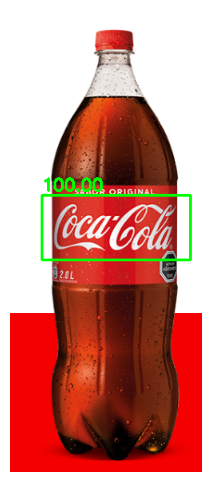

In [11]:
n_matches, max_match = sobel_match_template(cv.imread(r'images\coca_logo_1.png'),
                        cv.imread(r'template\pattern.png', cv.IMREAD_GRAYSCALE),
                        scale = 0.4,
                        detection_threshold = 0.3,
                        plot = True)

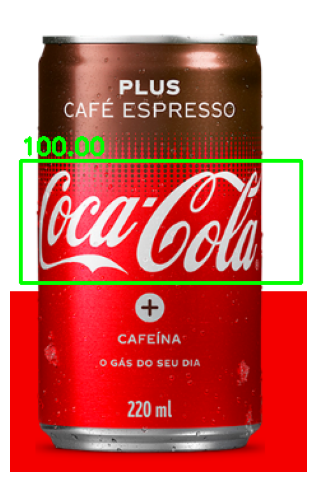

(1, np.int64(100))

In [12]:
sobel_match_template(cv.imread(r'images\coca_logo_2.png'),
                     cv.imread(r'template\pattern.png', cv.IMREAD_GRAYSCALE),
                     scale = 0.55,
                     detection_threshold = 0.17,
                     plot = True)

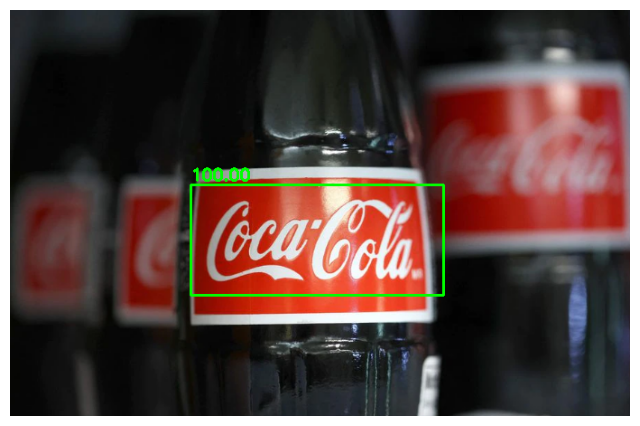

(1, np.int64(100))

In [13]:
sobel_match_template(cv.imread(r'images\logo_1.png'),
                     cv.imread(r'template\pattern.png', cv.IMREAD_GRAYSCALE),
                     scale = 0.7,
                     detection_threshold = 0.2,
                     plot = True)

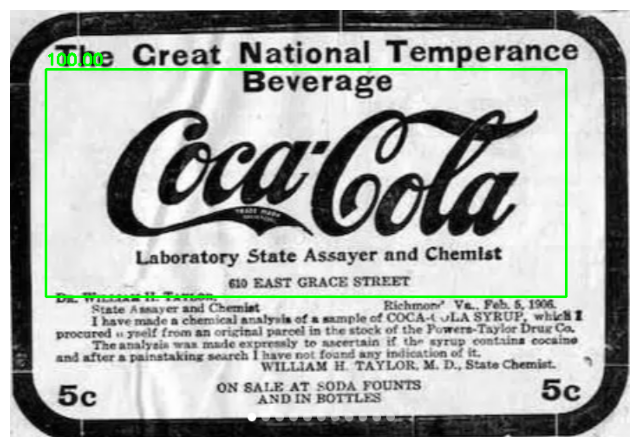

(1, np.int64(100))

In [14]:
sobel_match_template(cv.imread(r'images\coca_retro_1.png'),
                     cv.imread(r'template\pattern.png', cv.IMREAD_GRAYSCALE),
                     scale = 1.5,
                     detection_threshold = 0.1,
                     plot = True)

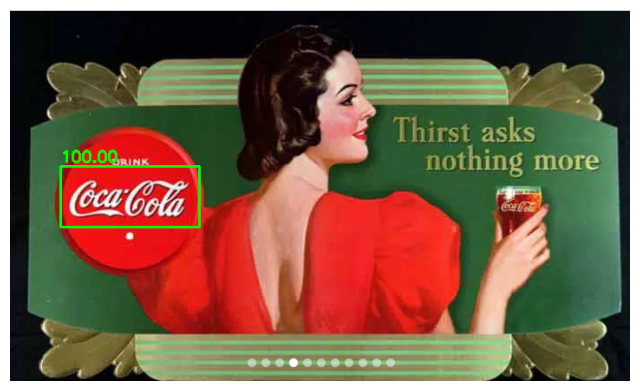

(1, np.int64(100))

In [15]:
sobel_match_template(cv.imread(r'images\coca_retro_2.png'),
                     cv.imread(r'template\pattern.png', cv.IMREAD_GRAYSCALE),
                     scale = 0.4,
                     detection_threshold = 0.25,
                     plot = True)

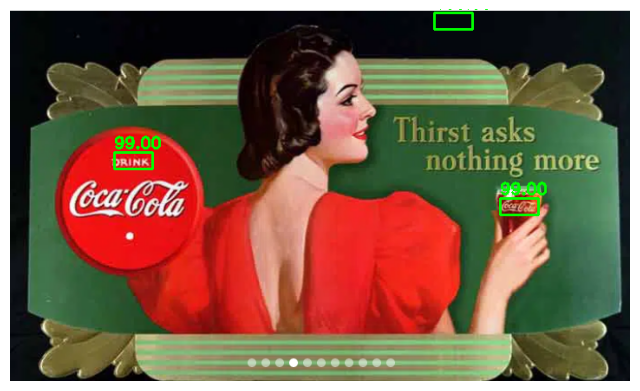

(3, np.int64(100))

In [ ]:
#El del vasito no colaboró mucho!

sobel_match_template(cv.imread(r'images\coca_retro_2.png'),
                     cv.imread(r'template\pattern.png', cv.IMREAD_GRAYSCALE),
                     scale = 0.11,
                     detection_threshold = 0.4,
                     plot = True)

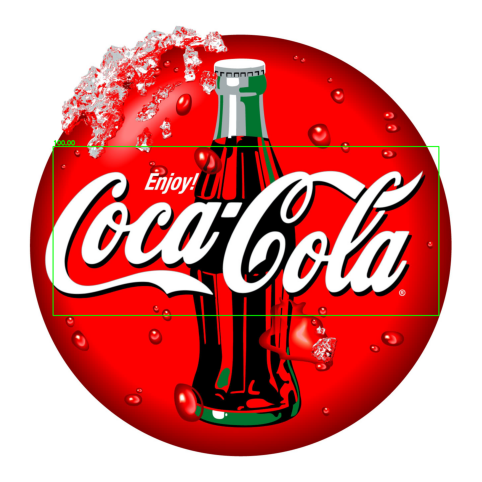

(1, np.int64(100))

In [17]:
sobel_match_template(cv.imread(r'images\COCA-COLA-LOGO.jpg'),
                     cv.imread(r'template\pattern.png', cv.IMREAD_GRAYSCALE),
                     scale = 2.9,
                     detection_threshold = 0.07,
                     plot = True)

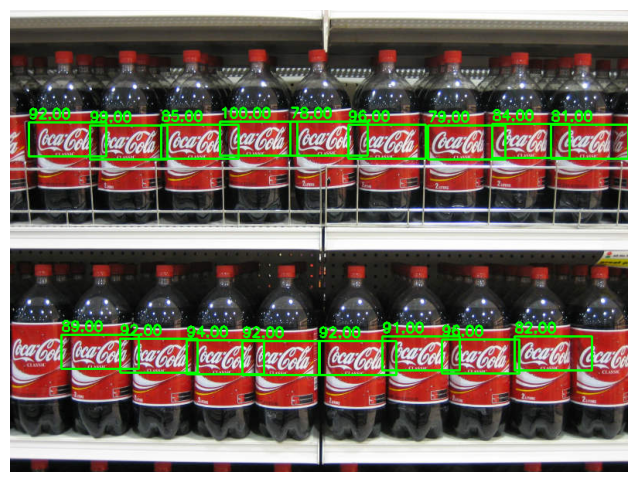

(17, np.int64(100))

In [18]:
sobel_match_template(cv.imread(r'images\coca_multi.png'),
                     cv.imread(r'template\pattern.png', cv.IMREAD_GRAYSCALE),
                     scale = 0.25,
                     detection_threshold = 0.3,
                     plot = True)

#### Implementación de búsqueda de parámetros

Se intentó implementar una búsqueda sistemática de parámetros, análoga a un *grid search*. Sin embargo, no fue posible definir una métrica compuesta suficientemente robusta que permitiera seleccionar el mejor *match* y, simultáneamente, descartar falsos positivos en escenarios con múltiples coincidencias espurias.

Con este propósito, se incorporó un parámetro booleano para desactivar la visualización durante el proceso iterativo de calibración. <br> 
El problema permanece abierto.

In [ ]:

scale_values = np.linspace(0.1, 3.0, 20)           
threshold_values = np.linspace(0.01, 3, 20)

best_score_tuple = (-1, 0)
best_params = {}
img_input = cv.imread(r'images\coca_logo_1.png')
template_input = cv.imread(r'template\pattern.png', cv.IMREAD_GRAYSCALE)

for scale in scale_values:
    for threshold in threshold_values:
        try:
            n_matches, max_match = sobel_match_template(
                img_input,
                template_input,
                scale=scale,
                detection_threshold=threshold
            )
            
            score_tuple = (max_match, -n_matches)
            
            if score_tuple > best_score_tuple:
                best_score_tuple = score_tuple
                best_params = {
                    "scale": scale,
                    "detection_threshold": threshold,
                    "n_matches": n_matches,
                    "max_match": max_match
                }
        except:
            continue

print("Mejor combinación según criterio jerárquico:")
print(best_params)


Mejor combinación según criterio jerárquico:
{'scale': np.float64(0.25263157894736843), 'detection_threshold': np.float64(0.1673684210526316), 'n_matches': 3, 'max_match': np.int64(100)}


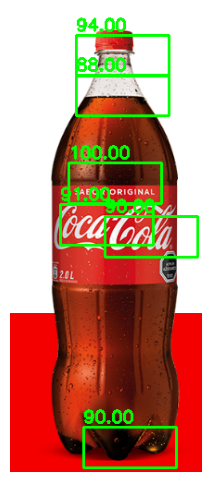

(6, np.int64(100))

In [20]:
#usando parámetros hallados:
sobel_match_template(cv.imread(r'images\coca_logo_1.png'),
                     cv.imread(r'template\pattern.png', cv.IMREAD_GRAYSCALE),
                     scale = 0.25,
                     detection_threshold = 0.17,
                     plot = True)